# Plot qPCR to analyze export from mouse (C3H10T1/2) and hamster (CHO) cells

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_mouse_hamster"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_mouse_hamster_Cq.csv"

cq_raw = pd.read_csv(infile, header=0)

columns_to_drop = ["Set Point"]
cq_raw.drop(columns_to_drop, axis=1, inplace=True)

cq_raw = cq_raw.set_index("Sample")

print(cq_raw.shape)
cq_raw.head()

(60, 12)


,Well,Fluor,Target,Content,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Sample,,,,,,,,,,,,
100-1,D01,SYBR,mCherry,Unkn-13,NaN,28.300181,28.081566,0.191335,564.594976,2.751737,655.296510,79.577090
100-2,D02,SYBR,mCherry,Unkn-14,NaN,27.005029,26.715159,0.252774,1323.654857,3.121775,1616.098581,255.578317
100-3,D03,SYBR,mCherry,Unkn-15,NaN,28.987272,28.924241,0.082522,359.276069,2.555428,374.858379,20.604818
100-4,D04,SYBR,mCherry,Unkn-16,NaN,26.983946,26.915219,0.228192,1342.141518,3.127798,1415.002920,218.210649
100-5,D05,SYBR,mCherry,Unkn-17,NaN,31.676880,31.693387,0.465606,61.232324,1.786981,62.469869,18.764423


In [5]:
# Load metadata (includes sample names)
infile = "../preprocessed_data/qPCR_data/qPCR_mouse_hamster_metadata.csv"
metadata = pd.read_csv(infile, index_col=0, header=0)
metadata = metadata.reset_index()
metadata = metadata.set_index("Sample")
print(metadata.shape)
metadata.head()

(20, 5)


,Cell Line,Condition,Full condition,Replicate,Expressing %
Sample,,,,,
99-1,HEK293T,EPN24-MCP + mCh-MS2x8,HEK293T EPN24-MCP + mCh-MS2x8,1,37.4
99-2,HEK293T,EPN24-MCP + mCh-MS2x8,HEK293T EPN24-MCP + mCh-MS2x8,2,39.4
99-3,HEK293T,Gag-MCP + mCh-MS2x8,HEK293T Gag-MCP + mCh-MS2x8,1,49.1
99-4,HEK293T,Gag-MCP + mCh-MS2x8,HEK293T Gag-MCP + mCh-MS2x8,2,51.2
99-5,HEK293T,mCh-MS2x8,HEK293T mCh-MS2x8,1,50.6


# Preprocess data

## Calculate total starting molecules

In [6]:
# Calculate normalization for input volume
DILUTION_FACTORS = (1000/140) * (42/20) * (61/10) * (20/1)

In [7]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [8]:
# Calculate total RNA molecules in supernatant
cq_raw["RNA molecules"] = cq_raw["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules Mean"] = cq_raw["SQ Mean"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules STD"] = cq_raw["SQ Std. Dev"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Calculate molecules per expressing cell

In [9]:
# Get number of cells and fraction expressing constructs
cq_raw["Expressing %"] = metadata.loc[cq_raw.index]["Expressing %"]

# Calculate molecules per expressing cell
cq_raw["RNA molecules normalized for expression rate"] = cq_raw["RNA molecules"] / (cq_raw["Expressing %"]/100)

# Calculate summary of replicates
cq_raw["RNA molecules Mean normalized for expression rate"] = cq_raw["RNA molecules Mean"] / (cq_raw["Expressing %"]/100)
cq_raw["RNA molecules STD normalized for expression rate"] = cq_raw["RNA molecules STD"] / (cq_raw["Expressing %"]/100)

## Summarize replicates

In [10]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary_raw = pd.DataFrame()

summary_raw["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary_raw["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary_raw["RNA molecules"] = groups["RNA molecules"].mean()
summary_raw["RNA molecules STD"] = groups["RNA molecules STD"].mean()


summary_raw["RNA molecules normalized for expression rate"] = groups["RNA molecules normalized for expression rate"].mean()
summary_raw["RNA molecules Mean normalized for expression rate"] = groups["RNA molecules Mean normalized for expression rate"].mean()
summary_raw["RNA molecules STD normalized for expression rate"] = groups["RNA molecules STD normalized for expression rate"].mean()

summary_raw

,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules normalized for expression rate,RNA molecules Mean normalized for expression rate,RNA molecules STD normalized for expression rate
Sample,,,,,,,
100-1,655.296510,79.577090,2.012804e+08,2.444284e+07,1.490966e+10,1.490966e+10,1.810581e+09
100-2,1616.098582,255.578317,4.963997e+08,7.850325e+07,3.677035e+10,3.677035e+10,5.815056e+09
100-3,374.858378,20.604818,1.151412e+08,6.328961e+06,6.773014e+10,6.773014e+10,3.722918e+09
100-4,1415.002920,218.210649,4.346313e+08,6.702543e+07,2.173156e+11,2.173156e+11,3.351271e+10
100-5,62.469869,18.764423,1.918820e+07,5.763667e+06,1.547436e+08,1.547436e+08,4.648118e+07
100-6,137.475070,25.110677,4.222675e+07,7.712978e+06,3.489814e+08,3.489814e+08,6.374362e+07
100-7,28.370584,11.367061,8.714289e+06,3.491498e+06,8.714289e+06,8.714289e+06,3.491498e+06
100-8,51.966488,2.901659,1.596199e+07,8.912715e+05,1.596199e+07,1.596199e+07,8.912715e+05
99-1,7590.410873,116.784119,2.331465e+09,3.587133e+07,6.233864e+09,6.233864e+09,9.591264e+07


## Summarize biological replicates

In [11]:
summary_raw["Full condition"] = metadata.loc[summary_raw.index, "Full condition"]

In [12]:
groups = summary_raw.groupby(["Full condition"])  # group samples by condition

summary = pd.DataFrame()

summary["mean SQ"] = groups["mean SQ"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["std SQ"].mean()  # Calculate mean over replicates

summary["RNA molecules"] = groups["RNA molecules"].mean()
summary["RNA molecules STD"] = groups["RNA molecules STD"].mean()


summary["RNA molecules normalized for expression rate"] = groups["RNA molecules normalized for expression rate"].mean()
summary["RNA molecules Mean normalized for expression rate"] = groups["RNA molecules Mean normalized for expression rate"].mean()
summary["RNA molecules STD normalized for expression rate"] = groups["RNA molecules STD normalized for expression rate"].mean()

summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules normalized for expression rate,RNA molecules Mean normalized for expression rate,RNA molecules STD normalized for expression rate
Full condition,,,,,,,
C3H EPN24-MCP + mCh-MS2x8,1135.697546,167.577703,3.488401e+08,5.147305e+07,2.584000e+10,2.584000e+10,3.812818e+09
C3H Gag-MCP + mCh-MS2x8,894.930649,119.407733,2.748863e+08,3.667719e+07,1.425229e+11,1.425229e+11,1.861782e+10
C3H No DNA,40.168536,7.134360,1.233814e+07,2.191385e+06,1.233814e+07,1.233814e+07,2.191385e+06
C3H mCh-MS2x8,99.972470,21.937550,3.070747e+07,6.738322e+06,2.518625e+08,2.518625e+08,5.511240e+07
CHOK1 EPN24-MCP + mCh-MS2x8,4143.833794,313.612888,1.272817e+09,9.632911e+07,3.403068e+09,3.403068e+09,2.563629e+08
CHOK1 Gag-MCP + mCh-MS2x8,25985.255850,1437.907946,7.981613e+09,4.416668e+08,1.671716e+10,1.671716e+10,9.233302e+08
CHOK1 No DNA,187.580211,14.932856,5.761700e+07,4.586766e+06,5.761700e+07,5.761700e+07,4.586766e+06
CHOK1 mCh-MS2x8,145.165107,21.242178,4.458881e+07,6.524732e+06,4.970882e+07,4.970882e+07,7.273949e+06
HEK293T EPN24-MCP + mCh-MS2x8,10039.024198,974.196185,3.083580e+09,2.992334e+08,7.984564e+09,7.984564e+09,7.619100e+08


## Censor by lower limit of quantification

In [13]:
# Lower limit of quantification is set based on maximum signal from highest negative control wells

LOD = cq_raw.loc["99-18", "RNA molecules normalized for expression rate"].max()

print("Lower limit of quantification:", LOD)

Lower limit of quantification: 62566922.23205994


In [14]:
# Substitute LOD for values below LOD

cq_raw["RNA molecules normalized for expression rate censored"] = cq_raw["RNA molecules normalized for expression rate"]
cq_raw.loc[cq_raw["RNA molecules normalized for expression rate"] < LOD, "RNA molecules normalized for expression rate censored"] = LOD

summary_raw["RNA molecules normalized for expression rate censored"] = summary_raw["RNA molecules normalized for expression rate"]
summary_raw.loc[summary_raw["RNA molecules normalized for expression rate"] < LOD, "RNA molecules normalized for expression rate censored"] = LOD

summary["RNA molecules normalized for expression rate censored"] = summary["RNA molecules normalized for expression rate"]
summary.loc[summary["RNA molecules normalized for expression rate"] < LOD, "RNA molecules normalized for expression rate censored"] = LOD

# Visualize RNA export from C3H/10T1/2

In [15]:
# Choose samples
index_ordered = ["C3H Gag-MCP + mCh-MS2x8",
                 "C3H EPN24-MCP + mCh-MS2x8",
                 "C3H mCh-MS2x8"]

In [16]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[index_ordered]

print(summary_subset.shape)
summary_subset

(3, 8)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules normalized for expression rate,RNA molecules Mean normalized for expression rate,RNA molecules STD normalized for expression rate,RNA molecules normalized for expression rate censored
Full condition,,,,,,,,
C3H Gag-MCP + mCh-MS2x8,894.930649,119.407733,2.748863e+08,3.667719e+07,1.425229e+11,1.425229e+11,1.861782e+10,1.425229e+11
C3H EPN24-MCP + mCh-MS2x8,1135.697546,167.577703,3.488401e+08,5.147305e+07,2.584000e+10,2.584000e+10,3.812818e+09,2.584000e+10
C3H mCh-MS2x8,99.972470,21.937550,3.070747e+07,6.738322e+06,2.518625e+08,2.518625e+08,5.511240e+07,2.518625e+08


In [17]:
# Get data of replicates of selected wells

# Map from full condition to samples
metadata_index_ordered = metadata.loc[metadata["Full condition"].isin(index_ordered)].index

selector = cq_raw.index.isin(metadata_index_ordered)
data = cq_raw.loc[selector]

data = data.reset_index()

print(data.shape)
data.head()

(18, 21)


,Sample,Well,Fluor,Target,Content,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,RNA molecules,RNA molecules Mean,RNA molecules STD,Expressing %,RNA molecules normalized for expression rate,RNA molecules Mean normalized for expression rate,RNA molecules STD normalized for expression rate,RNA molecules normalized for expression rate censored
0,100-1,D01,SYBR,mCherry,Unkn-13,NaN,28.300181,28.081566,0.191335,564.594976,2.751737,655.296510,79.577090,1.734206e+08,2.012804e+08,2.444284e+07,1.35,1.284597e+10,1.490966e+10,1.810581e+09,1.284597e+10
1,100-2,D02,SYBR,mCherry,Unkn-14,NaN,27.005029,26.715159,0.252774,1323.654857,3.121775,1616.098581,255.578317,4.065729e+08,4.963997e+08,7.850325e+07,1.35,3.011651e+10,3.677035e+10,5.815056e+09,3.011651e+10
2,100-3,D03,SYBR,mCherry,Unkn-15,NaN,28.987272,28.924241,0.082522,359.276069,2.555428,374.858379,20.604818,1.103550e+08,1.151412e+08,6.328961e+06,0.17,6.491470e+10,6.773014e+10,3.722918e+09,6.491470e+10
3,100-4,D04,SYBR,mCherry,Unkn-16,NaN,26.983946,26.915219,0.228192,1342.141518,3.127798,1415.002920,218.210649,4.122512e+08,4.346313e+08,6.702543e+07,0.20,2.061256e+11,2.173156e+11,3.351271e+10,2.061256e+11
4,100-5,D05,SYBR,mCherry,Unkn-17,NaN,31.676880,31.693387,0.465606,61.232324,1.786981,62.469869,18.764423,1.880808e+07,1.918820e+07,5.763667e+06,12.40,1.516780e+08,1.547436e+08,4.648118e+07,1.516780e+08


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


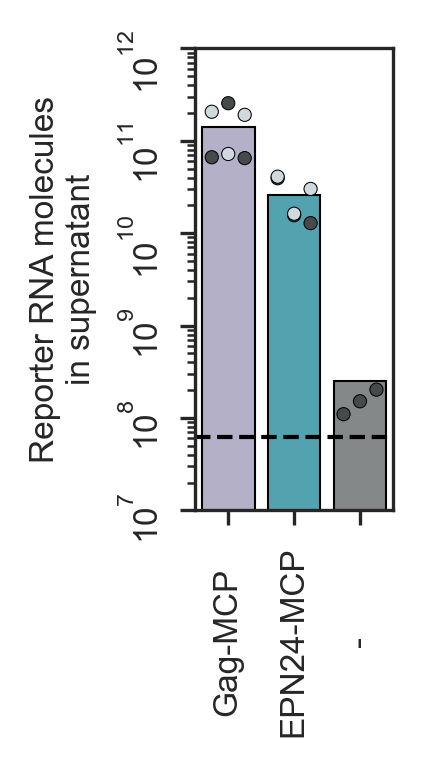

In [18]:
# Make simple bar plot, horizontal

field = "RNA molecules normalized for expression rate censored"

palette = ["#b1accc", "#44adbf", "#83888a"]  # set color of bars

# Set position of swarmplot dots
sample_to_rank = dict(zip(list(metadata_index_ordered), [1, 1, 0, 0, 2, 3, 3, 4, 4, 5, 6, 6, 7, 7, 8, 8]))

# fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))
fig, ax = plt.subplots(1, 1, figsize=(0.85, 2))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_yscale("log")
ax.set_ylim(1e7, 1e12)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.barplot(ax=ax, x=x, y=y, palette=palette, lw=0.5, edgecolor="#010101")

# Plot individual points as swarm (sort columns appropriately)
# sample_to_rank = dict(zip(list(metadata_index_ordered), [0, 0, 1, 1, 2, 6, 6, 7, 7, 8, 3, 3, 4, 4, 5, 5]))  # custom mapping to x position for swarm
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = data["rank"]

x_offset = np.array([-0.25, 0, 0.25])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

# Color by replicate well
colors_replicates = ["#474a4b", "#d0dade"]
color = [colors_replicates[0], colors_replicates[0], colors_replicates[0],
         colors_replicates[1], colors_replicates[1], colors_replicates[1]] * 2
color = color + [colors_replicates[0], colors_replicates[0], colors_replicates[0]] * 2


ax.scatter(x_swarm_offset, y_swarm, color=color, edgecolor="#010101", linewidths=0.25, s=10, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Reporter RNA molecules\nin supernatant", labelpad=6)

# ax.set_yticks([1, 10, 100, 1000])
# ax.set_yticklabels([1, 10, r"$10^2$", r"$10^3$"])

ax.set_xticks([0, 1, 2])
xticklabels = ["Gag-MCP", "EPN24-MCP", "-"]
ax.set_xticklabels(xticklabels, rotation=90, ha="center", va="center")
ax.tick_params(axis='x', which='major', pad=28)

ax.tick_params(axis='y', which='major', rotation=90)

# ax.text(-0.6, 0.58, "Exporter", ha="right", va="top", size=FONTSIZE)

ax.set_xlabel("")

ax.axhline(LOD, ls="--", color="k", lw=1)

# sns.despine()

save_figure(fig, "barplot_export_from_mouse_C3H")

# Visualize RNA export from CHO-K1

In [19]:
# Choose samples
index_ordered = ["CHOK1 Gag-MCP + mCh-MS2x8",
                 "CHOK1 EPN24-MCP + mCh-MS2x8",
                 "CHOK1 mCh-MS2x8"]

In [20]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[index_ordered]

print(summary_subset.shape)
summary_subset

(3, 8)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules normalized for expression rate,RNA molecules Mean normalized for expression rate,RNA molecules STD normalized for expression rate,RNA molecules normalized for expression rate censored
Full condition,,,,,,,,
CHOK1 Gag-MCP + mCh-MS2x8,25985.255850,1437.907946,7.981613e+09,4.416668e+08,1.671716e+10,1.671716e+10,9.233302e+08,1.671716e+10
CHOK1 EPN24-MCP + mCh-MS2x8,4143.833794,313.612888,1.272817e+09,9.632911e+07,3.403068e+09,3.403068e+09,2.563629e+08,3.403068e+09
CHOK1 mCh-MS2x8,145.165107,21.242178,4.458881e+07,6.524732e+06,4.970882e+07,4.970882e+07,7.273949e+06,6.256692e+07


In [21]:
# Get data of replicates of selected wells

# Map from full condition to samples
metadata_index_ordered = metadata.loc[metadata["Full condition"].isin(index_ordered)].index

selector = cq_raw.index.isin(metadata_index_ordered)
data = cq_raw.loc[selector]

data = data.reset_index()

print(data.shape)
data.head()

(15, 21)


,Sample,Well,Fluor,Target,Content,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,RNA molecules,RNA molecules Mean,RNA molecules STD,Expressing %,RNA molecules normalized for expression rate,RNA molecules Mean normalized for expression rate,RNA molecules STD normalized for expression rate,RNA molecules normalized for expression rate censored
0,99-13,D01,SYBR,mCherry,Unkn-13,NaN,24.026288,23.886132,0.123469,3976.071723,3.599454,4380.539025,357.196696,1.221287e+09,1.345523e+09,1.097163e+08,39.5,3.091867e+09,3.406388e+09,2.777627e+08,3.091867e+09
1,99-14,D02,SYBR,mCherry,Unkn-14,NaN,24.170305,24.054611,0.103926,3607.782284,3.557240,3907.128564,270.029081,1.108164e+09,1.200111e+09,8.294194e+07,35.3,3.139274e+09,3.399747e+09,2.349630e+08,3.139274e+09
2,99-15,D03,SYBR,mCherry,Unkn-15,NaN,21.473141,21.402710,0.066143,22275.474490,4.347827,23375.396450,1038.276557,6.842119e+09,7.179970e+09,3.189163e+08,47.2,1.449601e+10,1.521180e+10,6.756701e+08,1.449601e+10
3,99-16,D04,SYBR,mCherry,Unkn-16,NaN,21.011744,21.105148,0.095452,30413.778070,4.483070,28595.115260,1837.539329,9.341875e+09,8.783255e+09,5.644173e+08,48.2,1.938148e+10,1.822252e+10,1.170990e+09,1.938148e+10
4,99-17,D05,SYBR,mCherry,Unkn-17,NaN,28.699714,28.940864,0.209161,169.664355,2.229591,145.165107,21.242178,5.211398e+07,4.458881e+07,6.524732e+06,89.7,5.809809e+07,4.970882e+07,7.273949e+06,6.256692e+07


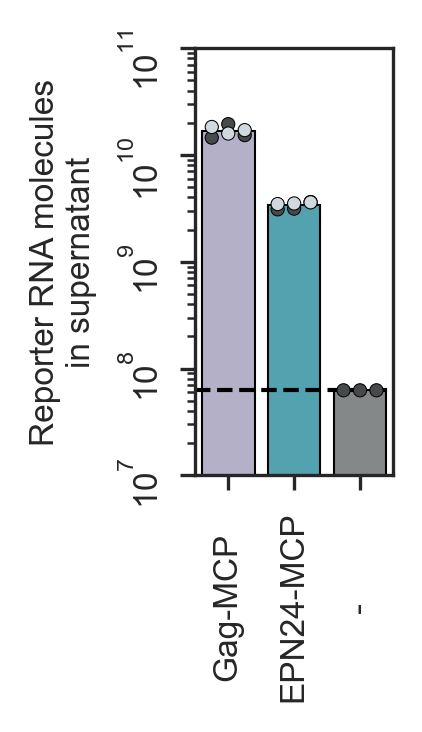

In [22]:
# Make simple bar plot, horizontal

field = "RNA molecules normalized for expression rate censored"

palette = ["#b1accc", "#44adbf", "#83888a"]  # set color of bars

# Set position of swarmplot dots
sample_to_rank = dict(zip(list(metadata_index_ordered), [1, 1, 0, 0, 2, 3, 3, 4, 4, 5, 6, 6, 7, 7, 8, 8]))

# fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))
fig, ax = plt.subplots(1, 1, figsize=(0.85, 1.85))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_yscale("log")
ax.set_ylim(1e7, 1e11)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.barplot(ax=ax, x=x, y=y, palette=palette, lw=0.5, edgecolor="#010101")

# Plot individual points as swarm (sort columns appropriately)
# sample_to_rank = dict(zip(list(metadata_index_ordered), [0, 0, 1, 1, 2, 6, 6, 7, 7, 8, 3, 3, 4, 4, 5, 5]))  # custom mapping to x position for swarm
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = data["rank"]

x_offset = np.array([-0.25, 0, 0.25])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

# Color by replicate well
colors_replicates = ["#474a4b", "#d0dade"]
color = [colors_replicates[0], colors_replicates[0], colors_replicates[0],
         colors_replicates[1], colors_replicates[1], colors_replicates[1]] * 2
color = color + [colors_replicates[0], colors_replicates[0], colors_replicates[0]] * 1


ax.scatter(x_swarm_offset, y_swarm, color=color, edgecolor="#010101", linewidths=0.25, s=10, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Reporter RNA molecules\nin supernatant", labelpad=6)

# ax.set_yticks([1, 10, 100, 1000])
# ax.set_yticklabels([1, 10, r"$10^2$", r"$10^3$"])

ax.set_xticks([0, 1, 2])
xticklabels = ["Gag-MCP", "EPN24-MCP", "-"]
ax.set_xticklabels(xticklabels, rotation=90, ha="center", va="center")
ax.tick_params(axis='x', which='major', pad=28)

ax.tick_params(axis='y', which='major', rotation=90)

# ax.text(-0.6, 0.58, "Exporter", ha="right", va="top", size=FONTSIZE)

ax.set_xlabel("")

ax.axhline(LOD, ls="--", color="k", lw=1)

# sns.despine()

save_figure(fig, "barplot_export_from_hamster_CHO")